# 05 - CNN Baseline

In questo notebook addestriamo un **modello CNN baseline** per la classificazione delle immagini di rifiuti.

**Obiettivi:**
- usare la pipeline `tf.data` definita in `src`
- addestrare una CNN semplice come baseline
- valutare le prestazioni su validation e test set

Questo modello rappresenta il primo vero modello “image-based” del progetto,
da confrontare con la baseline lineare.

#### 0) Import librerie e moduli progetto e setup path

Effettuo le seguenti operazioni a partire da:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`
- `src/garbagecls/dataset.py`

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


#### 1.0) Caricamento dati da DB e creazione dei 3 dataset con label_id

In [10]:
load_env()

df = read_images_df(source="raw_flat")
df_train, df_val, df_test = split_dfs(df) # df_test_our

label2id, id2label = build_label_maps(df["label"].unique())
num_classes = len(label2id)

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

print(f"num_classes: {num_classes}")
print(f"num_train: {len(df_train)}")
print(f"num_val: {len(df_val)}")
print(f"num_test: {len(df_test)}\n")

print(df_train.head())

num_classes: 6
num_train: 1768
num_val: 379
num_test: 380

   image_id                                  filepath      label  split  \
0         1       data/raw_flat/plastic/plastic92.jpg    plastic  train   
1         2  data/raw_flat/cardboard/cardboard305.jpg  cardboard  train   
2         3   data/raw_flat/cardboard/cardboard53.jpg  cardboard  train   
3         4   data/raw_flat/cardboard/cardboard42.jpg  cardboard  train   
4         5          data/raw_flat/metal/metal141.jpg      metal  train   

   width  height  channels    source  label_id  
0    512     384         3  raw_flat         4  
1    512     384         3  raw_flat         0  
2    512     384         3  raw_flat         0  
3    512     384         3  raw_flat         0  
4    512     384         3  raw_flat         2  


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


#### 1.1) Creazione tensori a partire dai df

In [12]:
IMG_SIZE = (192, 256)
BATCH_SIZE = 32
SEED = 42

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

#test_ds_our

num_classes

print(train_ds.element_spec,"\n")

print(train_ds)


(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)) 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


#### 2) Definizione CNN baseline

In [13]:
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 190, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 95, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 93, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 84480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,813,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,907,590 (41.61 MB)

 Trainable params: 10,907,590 (41.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 3) Compilazione e training

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Adam optimizer with a learning rate of 0.001 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print()
test_loss, test_acc = model.evaluate(test_ds) #test_ds_our in sostituzione quando verrà aggiunto
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - accuracy: 0.2958 - loss: 1.8435 - val_accuracy: 0.3588 - val_loss: 1.4567
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 438ms/step - accuracy: 0.4361 - loss: 1.3964 - val_accuracy: 0.4644 - val_loss: 1.3333
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.4977 - loss: 1.2465 - val_accuracy: 0.5066 - val_loss: 1.1886
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.5526 - loss: 1.1396 - val_accuracy: 0.5699 - val_loss: 1.1950
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - accuracy: 0.5583 - loss: 1.1425 - val_accuracy: 0.5435 - val_loss: 1.1719
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.6058 - loss: 1.0342 - val_accuracy: 0.6042 - val_loss: 0.9958
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.6301 - loss: 0.9687 - val_accuracy: 0.5858 - val_loss: 1.1520
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - accuracy: 0.6437 - loss: 0.9245 - val_accu

#### Salvataggio modello addestrato

In [16]:
from pathlib import Path
import datetime

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
model_path = MODELS_DIR / f"cnn_baseline_{stamp}.keras"

model.save(model_path)
print("Saved to:", model_path)

import json

info = {
  "img_size": IMG_SIZE,
  "batch_size": BATCH_SIZE,
  "seed": SEED,
  "val_acc_last": float(history.history["val_accuracy"][-1]),
  "test_acc": float(test_acc),
}

with open(MODELS_DIR / f"cnn_baseline_{stamp}.json", "w") as f:
    json.dump(info, f, indent=2)


Saved to: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_20260203-2007.keras


#### Caricamento modello (eventuale)

In [18]:
from tensorflow import keras
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
models_dir = PROJECT_ROOT / "models"

model_path = models_dir / "cnn_baseline_20260203-2007.keras"

print("Loading model from:", model_path)
model = keras.models.load_model(model_path)
model.summary()

print("Model loaded successfully.")


Loading model from: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_20260203-2007.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 190, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 95, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 93, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 84480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,813,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,722,772 (124.83 MB)

 Trainable params: 10,907,590 (41.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,815,182 (83.22 MB)

Model loaded successfully.


#### 4) Valutazione sul test set

In [19]:
test_loss, test_acc = model.evaluate(test_ds) #test_ds_our in sostituzione quando verrà aggiunto
print(f"Test accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5553 - loss: 1.1489
Test accuracy: 0.5553


#### 5) Curve di training

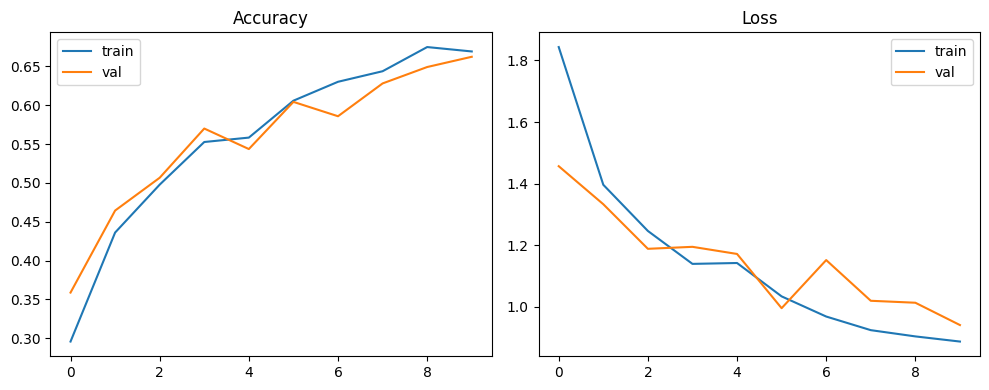

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**Train accuracy** cresce in modo regolare, mentre **validation accuracy** si stabilizza presto intorno a 0.60. Quindi il modello impara ma tendo ad un leggero overfitting, ma non collassa la curva val, quindi modello stabile.

**Train loss** descresce costantemente, mentre **validation loss** non lo fa in modo così marcato. Potremmo introdurre un early stopping

#### 6) Classification Report con Confusion Matrix

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1) predizioni
y_true = []
y_pred = []

for x_batch, y_batch in test_ds: #test_ds_our in sostituzione quando verrà aggiunto
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

# 2) confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Classification report:")
target_names = [id2label[i] for i in range(len(id2label))]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


Classification report:
              precision    recall  f1-score   support

   cardboard     0.7344    0.7833    0.7581        60
       glass     0.5500    0.2895    0.3793        76
       metal     0.4314    0.3548    0.3894        62
       paper     0.5448    0.8202    0.6547        89
     plastic     0.6538    0.4658    0.5440        73
       trash     0.3333    0.6500    0.4407        20

    accuracy                         0.5553       380
   macro avg     0.5413    0.5606    0.5277       380
weighted avg     0.5671    0.5553    0.5401       380



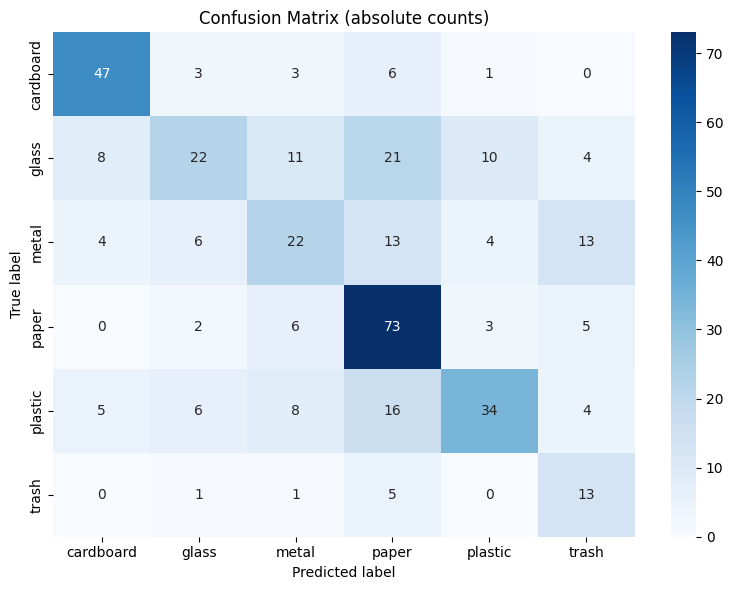

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (absolute counts)")
plt.tight_layout()
plt.show()


La **riga** di fatto ci mostra la `recall`, ovvero tra tutte quelle davvero della classe X, quante ne becco.

La **colonna** invece ci indica la `precision`, ovvero di quelle che ho predetto X, quante davvero lo sono.

**ESEMPIO:** Per *paper* ho una buona recall (0.82), ma una precision inferiore (0.54)


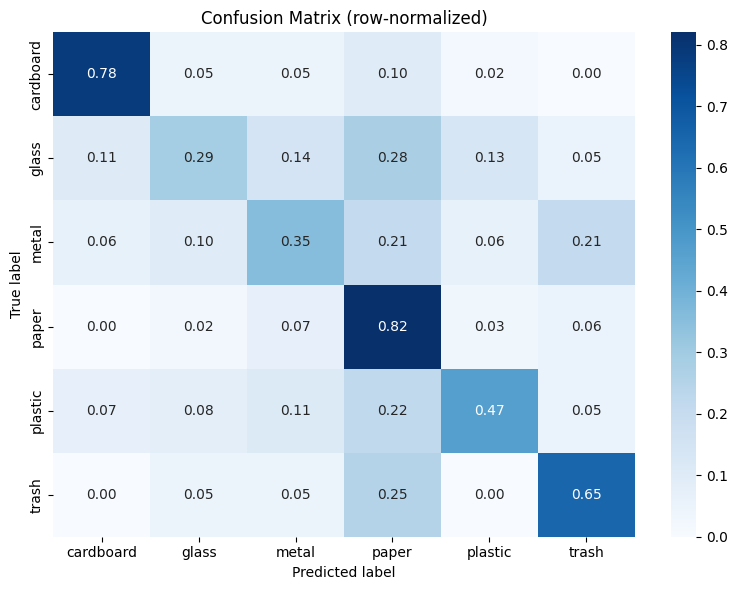

In [23]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()


## Considerazioni

- La CNN sfrutta la struttura spaziale delle immagini, a differenza della baseline lineare.

- Le prestazioni risultano migliori rispetto alla logistic regression raggiungendo un test accuracy di circa il 55% (rispetto al 35% della logistic regression). In particolare:  
  - Le curve di val e train mostrano un apprendimento stabile con leggero overfitting indicando che la pipeline e lo split dei dati è avvenuto in modo corretto.  
  - La confusion matrix evidenzia un buon risultato con cardboard, paper, ma evidenzia anche confusione sistematica con materiali simili (plastic vs paper, glass vs metal) suggerendo ulteriore lavoro per migliorare le performance.

- Questo modello costituisce un punto di partenza per:
  - architetture più profonde
  - transfer learning (es. MobileNet, ResNet)
